# Convolutional Neural Networks

In this exercise you will be introduced to some practical aspects of deep learning in
computer vision, including constructing a deep neural network and training it via gradient
descent to tackle image classification.

We will use the popular TensorFlow framework through the Keras API.

## Install TensorFlow

TensorFlow 2.0 will be released soon, but its beta version is already available. Install it using `pip install tensorflow==2.0.0-beta1` or if you have an Nvidia GPU, use  `pip install tensorflow-gpu==2.0.0-beta1`.

GPUs make the training many times faster, but since not all of you have an Nvidia GPU available, we have tried to scale the exercise with a CPU in mind.

## TensorBoard Plotting

TensorBoard is a web-based tool for drawing pretty plots of quantities we care about during training, such as the loss. We need to choose a folder where these values will be stored ("logdir").

Start the TensorBoard server by executing e.g. `tensorboard --logdir /tmp/tensorboard_logs` after you've activated your conda environment. If you change the logdir, also adjust it in the cell below.

You can view the graphs by visiting http://localhost:6006 in your browser (6006 is the default port).
At first there will be nothing to plot, so it will be empty. You can also open it afterwards in a separate browser 

In [1]:
log_root= '/work2/sarandi/temp/tensorboard_logs'

In [2]:
%matplotlib notebook
import os
import datetime
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
from attrdict import AttrDict
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.initializers as initializers
import tensorflow.keras.preprocessing.image as kerasimage
tfk = tf.keras
K = tfk.backend

def plot_multiple(images, titles=None, colormap='gray',
                  max_columns=np.inf, imwidth=4, imheight=4, share_axes=False):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [''] *len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()

## Dataset
We are going to tackle the classic image classification task using the **CIFAR-10 dataset**, containing 60,000 32x32 RGB images of 10 different classes (10,000 for training and 10,000 for testing). 

![image.png](cifar.png)

The dataset is automatically downloaded if you run the next cell.
You may read more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html.

A common normalization strategy is to map the image RGB values to the range 0-1 and subtract the mean pixel value across the training set.

In [3]:
dataset = tf.keras.datasets.cifar10
(im_train, y_train),(im_test, y_test) = dataset.load_data()
# Normalize to 0-1 range and subtract mean of training pixels
im_train = im_train / 255
im_test = im_test / 255

mean_training_pixel = np.mean(im_train, axis=(0,1,2))
x_train = im_train - mean_training_pixel
x_test = im_test - mean_training_pixel

image_shape = x_train[0].shape
labels = ['airplane','automobile','bird','cat',
          'deer','dog','frog','horse','ship','truck']

## Classification by Softmax Regression

Before considering convolutional neural networks, let us start with a simpler classifier called softmax regression (a.k.a. multinomial logistic regression). Note that even though the name contains "regression", this is a classification model.

It can be understood as a single-layer neural network. We first flatten our input image to a long vector $\mathbf{x}$, consisting of $32\cdot 32\cdot 3= 3072$ values. Then we predict class probabilities $\hat{\mathbf{y}}$ using a linear layer with softmax activation:

$$
\mathbf{z} = W \mathbf{x} + \mathbf{b}
$$

$$
\hat{y}_c = \operatorname{softmax}(\mathbf{z})_c = \frac{\exp{z_c}}{\sum_{\tilde{c}=1}^{10} \exp{z_{\tilde{c}}}}
$$

Here $z_c$ denotes the $c$th component of the vector $\mathbf{z}$, called the vector of **logits**. 
The weights $W$ and biases $\mathbf{b}$ will be learned during training.

## Training

We train the model by minimizing a **loss function** averaged over the training data. As we are tackling a classification problem, the **cross-entropy** is the suitable loss function:

$$
\mathcal{L}_{CE}(\mathbf{y}, \hat{\mathbf{y}}; W, \mathbf{b}) = - \sum_{c=1}^{10} y_c \log{\hat{y}_c}
$$

Note that in the above notation the ground-truth $\mathbf{y}$ is a so-called **one-hot vector**, containing a single 1 while the remaining components 
are zeros. Conversely, $\hat{\mathbf{y}}$ is a vector which sums to one, but where all components take continuous values in $(0, 1)$. What is the intuition behind this loss function?

We minimize the loss by **stochastic gradient descent** (SGD). That is, we repeatedly sample mini-batches from the training data and update the parameters (weights and biases) towards the direction of the steepest decrease of the loss averaged over the mini-batch. For example, the weight $w_{ij}$ (an element of the matrix $W$) is updated according to:

$$
w_{ij}^{(t+1)} = w_{ij}^{(t)} - \eta \cdot \frac{\partial \mathcal{L}_{CE}} {\partial w_{ij}},
$$

with $\eta$ being the learning rate.

----

This is all very simple to perform in Keras. `models.Sequential` accepts a list of layers that are applied sequentially, in a chain. Here we have two layers, `Flatten` to convert the image into a long vector and `Dense`, which is a fully-connected layer.

In [4]:
softmax_regression = models.Sequential([
    layers.Flatten(input_shape=image_shape),
    layers.Dense(10, activation='softmax')],
    name='linear')

def train_model(model, batch_size=128, n_epochs=100, optimizer=optimizers.SGD,
                learning_rate=1e-2):
    opt = optimizer(lr=learning_rate)
    model.compile(
        optimizer=opt, loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'])
    
    timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    logdir = os.path.join(log_root, f'{model.name}_{timestamp}')
    tensorboard_callback = callbacks.TensorBoard(logdir, profile_batch=0)
    model.fit(x=x_train, y=y_train, verbose=1, epochs=n_epochs, 
              validation_data=(x_test, y_test), batch_size=batch_size,
              callbacks=[tensorboard_callback])

In [5]:
train_model(softmax_regression, optimizer=optimizers.SGD, learning_rate=1e-2)

W0624 02:25:44.771519 139635184215872 deprecation.py:323] From /home/sarandi/anaconda3/envs/ml-tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 2s 39us/sample - loss: 1.9937 - accuracy: 0.3016 - val_loss: 1.8912 - val_accuracy: 0.3506
Epoch 2/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.8627 - accuracy: 0.3628 - val_loss: 1.8368 - val_accuracy: 0.3674
Epoch 3/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.8211 - accuracy: 0.3774 - val_loss: 1.8099 - val_accuracy: 0.3795
Epoch 4/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.7965 - accuracy: 0.3860 - val_loss: 1.7904 - val_accuracy: 0.3840
Epoch 5/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.7792 - accuracy: 0.3922 - val_loss: 1.7757 - val_accuracy: 0.3913
Epoch 6/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.7663 - accuracy: 0.3974 - val_loss: 1.7665 - val_accuracy: 0.3951
Epoch 7/100
50000/50000 [=========================

Epoch 55/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.6574 - accuracy: 0.4388 - val_loss: 1.7039 - val_accuracy: 0.4115
Epoch 56/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.6567 - accuracy: 0.4395 - val_loss: 1.7040 - val_accuracy: 0.4140
Epoch 57/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.6561 - accuracy: 0.4408 - val_loss: 1.7054 - val_accuracy: 0.4122
Epoch 58/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.6556 - accuracy: 0.4400 - val_loss: 1.7042 - val_accuracy: 0.4114
Epoch 59/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.6550 - accuracy: 0.4409 - val_loss: 1.7046 - val_accuracy: 0.4142
Epoch 60/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.6541 - accuracy: 0.4405 - val_loss: 1.7040 - val_accuracy: 0.4121
Epoch 61/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.6536 - ac

(Jupyter Notebook Tip: After you're done training, you can collapse or hide the output by clicking or double clicking the area directly to the left of the output.)

You can check the how the loss and accuracy change over the course of trainng in TensorBoard.

What would be the cross-entropy loss for a dummy classifier that always outputs equal probabilities for all the classes? 

## Adam Optimizer

There has been a lot of research on improving on the simple stochastic gradient descent algorithm. One of the most popular variants is called **Adam** (https://arxiv.org/abs/1412.6980, "adaptive moment estimation"). Its learning rate usually requires less precise tuning, and something in the range of $(10^{-4},10^{-3})$ often works well in practice. This is because the algorithm automatically adapts the learning rate for each weight depending on the gradients.

You can run it as follows (the optimizer is passed to Keras's `model.fit` function in `train_model`). The difference is not large for such a simple model, but makes a bigger difference for larger networks.

In [8]:
softmax_regression2 = models.Sequential([
    layers.Flatten(input_shape=image_shape),
    layers.Dense(10, activation='softmax')],
    name='linear')
train_model(softmax_regression2, optimizer=optimizers.Adam, n_epochs=100,
            learning_rate=2e-4)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 2s 36us/sample - loss: 1.9348 - accuracy: 0.3364 - val_loss: 1.8485 - val_accuracy: 0.3763
Epoch 2/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.8249 - accuracy: 0.3865 - val_loss: 1.8096 - val_accuracy: 0.3922
Epoch 3/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.7933 - accuracy: 0.3980 - val_loss: 1.7897 - val_accuracy: 0.3947
Epoch 4/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.7741 - accuracy: 0.4045 - val_loss: 1.7747 - val_accuracy: 0.4031
Epoch 5/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.7599 - accuracy: 0.4105 - val_loss: 1.7651 - val_accuracy: 0.4047
Epoch 6/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.7497 - accuracy: 0.4144 - val_loss: 1.7593 - val_accuracy: 0.4058
Epoch 7/100
50000/50000 [=========================

Epoch 55/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.6873 - accuracy: 0.4416 - val_loss: 1.7408 - val_accuracy: 0.4136
Epoch 56/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.6873 - accuracy: 0.4411 - val_loss: 1.7429 - val_accuracy: 0.4140
Epoch 57/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.6870 - accuracy: 0.4411 - val_loss: 1.7482 - val_accuracy: 0.4117
Epoch 58/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.6871 - accuracy: 0.4420 - val_loss: 1.7429 - val_accuracy: 0.4133
Epoch 59/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.6867 - accuracy: 0.4408 - val_loss: 1.7440 - val_accuracy: 0.4133
Epoch 60/100
50000/50000 [==============================] - 2s 33us/sample - loss: 1.6874 - accuracy: 0.4398 - val_loss: 1.7418 - val_accuracy: 0.4159
Epoch 61/100
50000/50000 [==============================] - 2s 32us/sample - loss: 1.6865 - ac

The learned weights $W$ can be interpreted as templates. Why is this so? Do they look as you would expect?

<IPython.core.display.Javascript object>


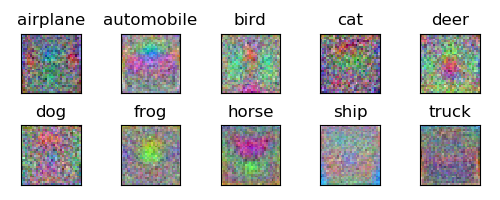

In [9]:
W, b = softmax_regression.layers[1].get_weights()
templates = W.reshape(32,32,3,10).transpose(3,0,1,2)
mini = np.min(templates, axis=(1,2,3), keepdims=True)
maxi = np.max(templates, axis=(1,2,3), keepdims=True)
rescaled_templates = (templates - mini)/ (maxi-mini)
plot_multiple(rescaled_templates, labels, max_columns=5,
              imwidth=1, imheight=1)

## Multi-Layer Perceptron

Softmax regression has a big limitation: the decision surface between any two classes (i.e. the part of the input space where the classification decision changes from one class to another) is a simple hyperplane ("flat").

The **multi-layer perceptron** (MLP) is a neural network model with additional layer(s) between the input and the logits (so-called hidden layers), with nonlinear activation functions. Why are activation functions needed?

Before recent years, the **hyperbolic tangent** (tanh) function used to be the preferred activation function in hidden layers of MLPs. It is sigmoid shaped and has a range of $(-1,1)$. We can create this in Keras as follows. Does it obtain better results than the linear model?

In [10]:
tanh_mlp = models.Sequential([
    layers.Flatten(input_shape=image_shape),
    layers.Dense(512, activation='tanh'),
    layers.Dense(10, activation='softmax')],
    name='tanh_mlp')

train_model(tanh_mlp, optimizer=optimizers.Adam, learning_rate=2e-4)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 2s 37us/sample - loss: 1.8144 - accuracy: 0.3726 - val_loss: 1.7377 - val_accuracy: 0.3960
Epoch 2/100
50000/50000 [==============================] - 2s 34us/sample - loss: 1.6811 - accuracy: 0.4244 - val_loss: 1.6751 - val_accuracy: 0.4244
Epoch 3/100
50000/50000 [==============================] - 2s 34us/sample - loss: 1.6170 - accuracy: 0.4467 - val_loss: 1.6528 - val_accuracy: 0.4309
Epoch 4/100
50000/50000 [==============================] - 2s 34us/sample - loss: 1.5625 - accuracy: 0.4669 - val_loss: 1.6088 - val_accuracy: 0.4518
Epoch 5/100
50000/50000 [==============================] - 2s 34us/sample - loss: 1.5155 - accuracy: 0.4864 - val_loss: 1.5783 - val_accuracy: 0.4588
Epoch 6/100
50000/50000 [==============================] - 2s 35us/sample - loss: 1.4742 - accuracy: 0.5009 - val_loss: 1.5647 - val_accuracy: 0.4620
Epoch 7/100
50000/50000 [=========================

Epoch 55/100
50000/50000 [==============================] - 2s 33us/sample - loss: 0.2548 - accuracy: 0.9563 - val_loss: 1.8128 - val_accuracy: 0.4881
Epoch 56/100
50000/50000 [==============================] - 2s 33us/sample - loss: 0.2471 - accuracy: 0.9567 - val_loss: 1.8182 - val_accuracy: 0.4885
Epoch 57/100
50000/50000 [==============================] - 2s 33us/sample - loss: 0.2323 - accuracy: 0.9621 - val_loss: 1.8365 - val_accuracy: 0.4878
Epoch 58/100
50000/50000 [==============================] - 2s 33us/sample - loss: 0.2213 - accuracy: 0.9644 - val_loss: 1.8618 - val_accuracy: 0.4901
Epoch 59/100
50000/50000 [==============================] - 2s 33us/sample - loss: 0.2111 - accuracy: 0.9675 - val_loss: 1.8676 - val_accuracy: 0.4858
Epoch 60/100
50000/50000 [==============================] - 2s 33us/sample - loss: 0.2020 - accuracy: 0.9699 - val_loss: 1.8931 - val_accuracy: 0.4856
Epoch 61/100
50000/50000 [==============================] - 2s 33us/sample - loss: 0.1929 - ac

## ReLU

The ReLU activation function has become more popular in recent years, especially for deeper nets. Create and train an MLP that uses ReLU as the activation. Do the results change? What benefits does ReLU have against tanh?

Good random initialization of weights is important (espeacially for deeper networks). For layers followed by ReLU activation, He et al. (https://arxiv.org/abs/1502.01852) recommend initializing the weights by sampling from a distribution with variance $2/fan_{in}$, where fan in refers to the number of inputs to each unit in the layer. This can be used in Keras simply by setting `kernel_initializer='he_normal'`.

In [12]:
relu_mlp = models.Sequential([
    layers.Flatten(input_shape=image_shape),
    layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dense(10, activation='softmax')],
    name='relu_mlp_l2reg')
train_model(relu_mlp, optimizer=optimizers.Adam, learning_rate=2e-4)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 2s 41us/sample - loss: 2.5593 - accuracy: 0.4220 - val_loss: 2.2894 - val_accuracy: 0.4717
Epoch 2/100
50000/50000 [==============================] - 2s 36us/sample - loss: 2.1301 - accuracy: 0.4893 - val_loss: 2.0250 - val_accuracy: 0.4878
Epoch 3/100
50000/50000 [==============================] - 2s 36us/sample - loss: 1.8897 - accuracy: 0.5171 - val_loss: 1.8520 - val_accuracy: 0.5014
Epoch 4/100
50000/50000 [==============================] - 2s 36us/sample - loss: 1.7340 - accuracy: 0.5371 - val_loss: 1.7456 - val_accuracy: 0.5155
Epoch 5/100
50000/50000 [==============================] - 2s 35us/sample - loss: 1.6238 - accuracy: 0.5493 - val_loss: 1.6700 - val_accuracy: 0.5159
Epoch 6/100
50000/50000 [==============================] - 2s 34us/sample - loss: 1.5526 - accuracy: 0.5587 - val_loss: 1.6151 - val_accuracy: 0.5201
Epoch 7/100
50000/50000 [=========================

Epoch 55/100
50000/50000 [==============================] - 2s 37us/sample - loss: 1.2061 - accuracy: 0.7142 - val_loss: 1.5859 - val_accuracy: 0.5618
Epoch 56/100
50000/50000 [==============================] - 2s 36us/sample - loss: 1.2056 - accuracy: 0.7153 - val_loss: 1.6001 - val_accuracy: 0.5514
Epoch 57/100
50000/50000 [==============================] - 2s 35us/sample - loss: 1.2046 - accuracy: 0.7168 - val_loss: 1.5913 - val_accuracy: 0.5570
Epoch 58/100
50000/50000 [==============================] - 2s 37us/sample - loss: 1.2039 - accuracy: 0.7163 - val_loss: 1.6055 - val_accuracy: 0.5548
Epoch 59/100
50000/50000 [==============================] - 2s 38us/sample - loss: 1.2007 - accuracy: 0.7194 - val_loss: 1.6164 - val_accuracy: 0.5546
Epoch 60/100
50000/50000 [==============================] - 2s 37us/sample - loss: 1.2017 - accuracy: 0.7198 - val_loss: 1.6059 - val_accuracy: 0.5531
Epoch 61/100
50000/50000 [==============================] - 2s 34us/sample - loss: 1.2033 - ac

## A Simple Convolutional Neural Network

The previous models did not explicitly make use of the grid structure of the image pixels. Convolutional neural networks do.

Instead of reshaping the input into a long vector, convolutional layers slide small filters across the input, just as with the convolutional filters we saw earlier in the course. In the earlier parts, we looked at convolution on an image with a single channel in case of grayscale images, or channelwise separate convolutions on RGB images. In CNNs, the multiple input channels of a conv layer are not handled independently, but are linearly combined. This means that the weight array has shape `[kernel_height, kernel_width, num_input_channels, num_output_channels]` and we perform a weighted sum along the channel axis. Another difference is the use of a **bias** vector of shape `[num_output_channels]`, each component of which gets added on the corresponding output channel.

As you already know, convolution is a linear operator, so it is possible to express any convolutional layer as a fully-connected layer.
However, the convolutional layer's weight matrix is sparse (has many zeros) compared to a fully-connected ("dense") layer because each output only depends on a small number of inputs, namely, those within a small neigborhood. Further, the weight values are shared between the different pixel locations.

This tutorial has some great visualisations and explanations if you would like to know more: https://arxiv.org/abs/1603.07285.

**Q:** Assuming a fixed input image size, do you think the reverse of the above also holds? Can any fully-connected layer be expressed as a convolutional layer?

**Q:** Technically, what's called a "convolutional" layer is usually implemented as a *cross-correlation* computation. Could there be any advantage in using the actual definition of convolution in these layers?

Train the following simple CNN model. It may take about 15 minutes on a CPU.

In [14]:
cnn = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', 
                  kernel_initializer='he_uniform', padding='same', 
                  input_shape=image_shape, kernel_regularizer=regularizers.l2(1e-3)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', 
                  kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(1e-3)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-3))],
    name='cnn')

train_model(cnn, optimizer=optimizers.Adam, learning_rate=1e-3, n_epochs=100)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 3s 55us/sample - loss: 1.6386 - accuracy: 0.5095 - val_loss: 1.3652 - val_accuracy: 0.6084
Epoch 2/100
50000/50000 [==============================] - 2s 50us/sample - loss: 1.2897 - accuracy: 0.6326 - val_loss: 1.2313 - val_accuracy: 0.6511
Epoch 3/100
50000/50000 [==============================] - 3s 51us/sample - loss: 1.1653 - accuracy: 0.6761 - val_loss: 1.1641 - val_accuracy: 0.6798
Epoch 4/100
50000/50000 [==============================] - 3s 51us/sample - loss: 1.0950 - accuracy: 0.7023 - val_loss: 1.1380 - val_accuracy: 0.6832
Epoch 5/100
50000/50000 [==============================] - 3s 53us/sample - loss: 1.0459 - accuracy: 0.7195 - val_loss: 1.1131 - val_accuracy: 0.6939
Epoch 6/100
50000/50000 [==============================] - 3s 50us/sample - loss: 1.0130 - accuracy: 0.7312 - val_loss: 1.1054 - val_accuracy: 0.6979
Epoch 7/100
50000/50000 [=========================

Epoch 55/100
50000/50000 [==============================] - 2s 49us/sample - loss: 0.8079 - accuracy: 0.8301 - val_loss: 1.0842 - val_accuracy: 0.7313
Epoch 56/100
50000/50000 [==============================] - 2s 48us/sample - loss: 0.8057 - accuracy: 0.8299 - val_loss: 1.0708 - val_accuracy: 0.7356
Epoch 57/100
50000/50000 [==============================] - 2s 48us/sample - loss: 0.8039 - accuracy: 0.8309 - val_loss: 1.0704 - val_accuracy: 0.7341
Epoch 58/100
50000/50000 [==============================] - 2s 48us/sample - loss: 0.8010 - accuracy: 0.8324 - val_loss: 1.0553 - val_accuracy: 0.7410
Epoch 59/100
50000/50000 [==============================] - 2s 48us/sample - loss: 0.8032 - accuracy: 0.8321 - val_loss: 1.0797 - val_accuracy: 0.7329
Epoch 60/100
50000/50000 [==============================] - 2s 48us/sample - loss: 0.8041 - accuracy: 0.8322 - val_loss: 1.0662 - val_accuracy: 0.7392
Epoch 61/100
50000/50000 [==============================] - 2s 48us/sample - loss: 0.8010 - ac

**Q:** Does it improve the result? Does it run faster than the MLP? How many parameters does this model have?

**Q:** How large is the output space of the first convolutional layer? How does this compare to the size of the hidden layer in the MLP?

## Implementing a CNN Forward Pass

To confirm your understanding of the main CNN components, implement the forward pass of the convolutional, max pooling and dense layers, plus the relu and softmax activation functions. For simplicity, assume a fixed filter size of 3x3 for the convolution, with stride 1 and use zero padding, such that the spatial size does not change ('same' padding). Implement this in `conv3x3_same`. For max pooling assume a fixed 2x2 pooling size and stride 2 in `maxpool2x2`.

We can extract the weights from the trained Keras model, feed them and an input through your implementation of the forward pass and compare the results.

You can also generalize these to other filter sizes and strides.
(Implementation of the backward pass does not fit within this exercise, but the "Machine Learning" course of our chair does include such exercises.)

Congratulations, you got correct results!


<IPython.core.display.Javascript object>


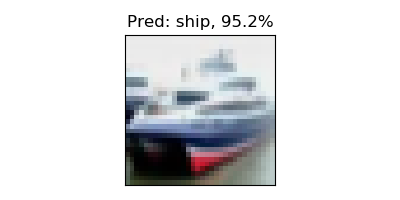

In [24]:
def conv3x3_same(x, weights, biases):
    """Convolutional layer with filter size 3x3 and 'same' padding.
    `x` is a NumPy array of shape [height, width, n_features_in]
    `weights` has shape [3, 3, n_features_in, n_features_out]
    `biases` has shape [n_features_out]
    Return the output of the 3x3 conv (without activation)
    """
    ### BEGIN SOLUTION
    x = np.pad(x, [(1, 1), (1, 1), (0, 0)], mode='constant')
    result = np.empty((x.shape[0], x.shape[1], weights.shape[3]))
    for i in range(1, x.shape[0] - 1):
        for j in range(1, x.shape[1] - 1):
            roi = x[i-1:i+2, j-1:j+2]
            for c_out in range(weights.shape[3]):
                result[i, j, c_out] = np.sum(roi * weights[..., c_out])
                
    result = result[1:-1, 1:-1]
    result += biases
    ### END SOLUTION
    return result

def maxpool2x2(x):
    """Max pooling with pool size 2x2 and stride 2.
    `x` is a numpy array of shape [height, width, n_features]
    """
    ### BEGIN SOLUTION
    result = np.empty((x.shape[0]//2, x.shape[1]//2, x.shape[2]))
    for i in range(0, result.shape[0]):
        for j in range(0, result.shape[1]):
            roi = x[i*2:i*2+2, j*2:j*2+2]
            result[i, j] = np.max(roi, axis=(0,1))
    ### END SOLUTION
    return result

def dense(x, weights, biases):
    ### BEGIN SOLUTION
    return x.T @ weights + biases
    ### END SOLUTION
    
def relu(x):
    ### BEGIN SOLUTION
    return np.maximum(0, x)
    ### END SOLUTION

def softmax(x):
    ### BEGIN SOLUTION
    maxi = np.max(x)
    exponentiated = np.exp(x - maxi)
    return exponentiated / np.sum(exponentiated)
    ### END SOLUTION

def my_predict_cnn(x, W1, b1, W2, b2, W3, b3):
    x = conv3x3_same(x, W1, b1)
    x = relu(x)
    x = maxpool2x2(x)
    x = conv3x3_same(x, W2, b2)
    x = relu(x)
    x = maxpool2x2(x)
    x = x.reshape(-1)
    x = dense(x, W3, b3)
    x = softmax(x)
    return x

W1, b1 = cnn.layers[0].get_weights()
W2, b2 = cnn.layers[2].get_weights()
W3, b3 = cnn.layers[5].get_weights()

i_test = 1
inp = x_test[i_test]
my_prob = my_predict_cnn(inp, W1, b1, W2, b2, W3, b3)
keras_prob = cnn.predict(inp[np.newaxis])[0]
if np.mean((my_prob-keras_prob)**2) > 1e-10:
    print('Something isn\'t right! Keras gives different'
          'results than my_predict_cnn!')
else:
    print('Congratulations, you got correct results!')
    
i_maxpred = np.argmax(my_prob)
plot_multiple([im_test[i_test]], 
              [f'Pred: {labels[i_maxpred]}, {my_prob[i_maxpred]:.1%}'],
              imheight=2)

## Batch Normalization

Batch normalization is a modern technique to improve and speed up the training of deep neural networks (BatchNorm, Ioffe & Szegedy ICML'15, https://arxiv.org/abs/1502.03167). Each feature channel is normalized to have zero mean and unit variance across the spatial and mini-batch axes. To compensate for the lost degrees of freedom, extra scaling and bias parameters are introduced and learned. Mathematically, BatchNorm for a spatial feature map (e.g. the output of conv) can be written as:

$$
\mu_d = \mathbb{E}\{x_{\cdot \cdot d}\},
$$

$$
\sigma_d = \sqrt{\operatorname{Var}\{x_{\cdot \cdot d}\}}
$$

$$
z_{ijd} = \gamma_d \cdot \frac{x_{ijd} - \mu_d}{\sigma_d} + \beta_d,
$$

with the expectation and variance taken across both the data samples of the batch and the spatial dimensions.

The $\mu_d$ and $\sigma_d$ values are computed on the actual mini-batch during training, but at test-time they are fixed, so that the prediction of the final system on a given sample does not depend on other samples in the mini-batch. To obtain the fixed values for test-time use, one needs to maintain moving statistics over the activations during training. This can be a bit tricky to implement from scratch, but luckily this is now implemented in all popular frameworks, including TensorFlow and Keras.

**Q:** When applying BatchNorm, it is not necessary to use biases in the previous convolutional layer. Can you explain why?

**Q:** Furthermore, if the BatchNorm is followed by a linear or conv layer (with perhaps a ReLU in between), it is not necessary to use the $\gamma_d$ factor in BatchNorm (it can be turned off as `layers.BatchNormalization(scale=False)`). Why?

Create a modified version of the previous model, where the `Conv2D` layers don't include the activation any more, and instead, insert a `layers.BatchNormalization()` and a `layers.Activation('relu')` layer after each conv. Does the resulting model obtain better results?

In [29]:
cnn_batchnorm = ...

### BEGIN SOLUTION
cnn_batchnorm = models.Sequential([
    layers.Conv2D(64, (3, 3), use_bias=False,
                  padding='same', input_shape=image_shape),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), (2,2)),
    layers.Conv2D(64, (3, 3), use_bias=False,
                  padding='same'),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), (2, 2)),
    layers.Flatten(),
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-3))],
    name='cnn_batchnorm')
### END SOLUTION

train_model(cnn_batchnorm, optimizer=optimizers.Adam,
            learning_rate=1e-3, n_epochs=100)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 4s 73us/sample - loss: 1.4165 - accuracy: 0.5131 - val_loss: 2.2776 - val_accuracy: 0.2902
Epoch 2/100
50000/50000 [==============================] - 3s 62us/sample - loss: 1.0363 - accuracy: 0.6481 - val_loss: 0.9933 - val_accuracy: 0.6650
Epoch 3/100
50000/50000 [==============================] - 3s 59us/sample - loss: 0.9119 - accuracy: 0.6944 - val_loss: 1.0664 - val_accuracy: 0.6366
Epoch 4/100
50000/50000 [==============================] - 3s 60us/sample - loss: 0.8392 - accuracy: 0.7200 - val_loss: 0.9486 - val_accuracy: 0.6886
Epoch 5/100
50000/50000 [==============================] - 3s 60us/sample - loss: 0.7844 - accuracy: 0.7382 - val_loss: 0.8666 - val_accuracy: 0.7139
Epoch 6/100
50000/50000 [==============================] - 3s 60us/sample - loss: 0.7447 - accuracy: 0.7563 - val_loss: 0.9227 - val_accuracy: 0.7015
Epoch 7/100
50000/50000 [=========================

Epoch 55/100
50000/50000 [==============================] - 3s 57us/sample - loss: 0.3292 - accuracy: 0.9430 - val_loss: 1.0040 - val_accuracy: 0.7351
Epoch 56/100
50000/50000 [==============================] - 3s 58us/sample - loss: 0.3202 - accuracy: 0.9488 - val_loss: 1.0192 - val_accuracy: 0.7376
Epoch 57/100
50000/50000 [==============================] - 3s 57us/sample - loss: 0.3214 - accuracy: 0.9465 - val_loss: 0.9790 - val_accuracy: 0.7415
Epoch 58/100
50000/50000 [==============================] - 3s 57us/sample - loss: 0.3200 - accuracy: 0.9479 - val_loss: 0.9684 - val_accuracy: 0.7432
Epoch 59/100
50000/50000 [==============================] - 3s 58us/sample - loss: 0.3169 - accuracy: 0.9486 - val_loss: 0.9727 - val_accuracy: 0.7470
Epoch 60/100
50000/50000 [==============================] - 3s 58us/sample - loss: 0.3182 - accuracy: 0.9489 - val_loss: 0.9852 - val_accuracy: 0.7398
Epoch 61/100
50000/50000 [==============================] - 3s 57us/sample - loss: 0.3078 - ac

## Strided Convolutions

Max-pooling is a popular technique for reducing the spatial dimensionality
of the outputs from conv layers. However, researchers such as Springenberg et al. have argued
that simple striding can achieve similar accuracy (https://arxiv.org/pdf/1412.6806.pdf). 

Now create a model using the same architecture as before, with the difference of
removing the pooling layers and increasing the stride parameter of the conv layers to $2 \times 2$ in the spatial dimensions. 

What differences do you notice when running the training?
What seems to be a clear advantage for using strides and why?

In [5]:
cnn_strides = ...
### BEGIN SOLUTION
cnn_strides = models.Sequential([
    layers.Conv2D(64, 3, strides=2, use_bias=False, 
                  padding='same', input_shape=image_shape),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, strides=2, use_bias=False, padding='same'),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-3))],
    name='cnn_strides')
### END SOLUTION

train_model(cnn_strides, optimizer=optimizers.Adam,
            learning_rate=1e-3, n_epochs=100)

W0624 03:23:35.891220 140494717568832 deprecation.py:323] From /home/sarandi/anaconda3/envs/ml-tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 4s 82us/sample - loss: 1.4634 - accuracy: 0.4901 - val_loss: 2.4058 - val_accuracy: 0.2717
Epoch 2/100
50000/50000 [==============================] - 2s 49us/sample - loss: 1.1055 - accuracy: 0.6195 - val_loss: 1.0847 - val_accuracy: 0.6282
Epoch 3/100
50000/50000 [==============================] - 2s 48us/sample - loss: 0.9696 - accuracy: 0.6716 - val_loss: 1.0455 - val_accuracy: 0.6449
Epoch 4/100
50000/50000 [==============================] - 2s 49us/sample - loss: 0.8842 - accuracy: 0.7069 - val_loss: 1.0198 - val_accuracy: 0.6605
Epoch 5/100
50000/50000 [==============================] - 3s 51us/sample - loss: 0.8277 - accuracy: 0.7286 - val_loss: 1.0218 - val_accuracy: 0.6602
Epoch 6/100
50000/50000 [==============================] - 3s 53us/sample - loss: 0.7867 - accuracy: 0.7454 - val_loss: 0.9738 - val_accuracy: 0.6841
Epoch 7/100
50000/50000 [=========================

Epoch 55/100
50000/50000 [==============================] - 3s 53us/sample - loss: 0.3868 - accuracy: 0.9363 - val_loss: 1.2466 - val_accuracy: 0.6791
Epoch 56/100
50000/50000 [==============================] - 2s 50us/sample - loss: 0.3788 - accuracy: 0.9391 - val_loss: 1.2279 - val_accuracy: 0.6879
Epoch 57/100
50000/50000 [==============================] - 2s 49us/sample - loss: 0.3762 - accuracy: 0.9400 - val_loss: 1.2479 - val_accuracy: 0.6753
Epoch 58/100
50000/50000 [==============================] - 2s 50us/sample - loss: 0.3814 - accuracy: 0.9370 - val_loss: 1.2153 - val_accuracy: 0.6891
Epoch 59/100
50000/50000 [==============================] - 2s 49us/sample - loss: 0.3778 - accuracy: 0.9396 - val_loss: 1.2558 - val_accuracy: 0.6805
Epoch 60/100
50000/50000 [==============================] - 3s 53us/sample - loss: 0.3703 - accuracy: 0.9429 - val_loss: 1.2751 - val_accuracy: 0.6775
Epoch 61/100
50000/50000 [==============================] - 2s 48us/sample - loss: 0.3757 - ac

## Global Pooling

The above network ends in a `Flatten` layer followed by a `Dense` layer, in which the number of weights depends on the input size. This means that testing can only be performed on the exact same image size. Instead of flattening, several architectures employ a (spatial) **global average pooling layer** to produce of vector of fixed size that is independent of image size, describing the whole image. This is simply the spatial average of the feature values over each feature channel.

For this to work well, the units before the average pooling need to have a large enough receptive field. Therefore, compared with the previous model, remove the `Flatten` layer and instead add a third Conv-BatchNorm-ReLU combination, followed by a `layers.GlobalAveragePooling2D()` layer (before the final `Dense` layer).

**Q:** Which network has more parameters, this or the previous one?

**Q:** What is the receptive field of the units in the layer directly before the global average pooling?

Train it and see if it reaches similar accuracy to the previous one.

In [6]:
cnn_global_pool = ...

### BEGIN SOLUTION
cnn_global_pool = models.Sequential([
    layers.Conv2D(64, 3, 2, padding='same', use_bias=False),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, 2, padding='same', use_bias=False),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same', use_bias=False),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-3))],
    name='cnn_global_pool')
### END SOLUTION

train_model(cnn_global_pool, optimizer=optimizers.Adam, learning_rate=1e-3)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 4s 70us/sample - loss: 1.5961 - accuracy: 0.4367 - val_loss: 2.6062 - val_accuracy: 0.1641
Epoch 2/100
50000/50000 [==============================] - 3s 56us/sample - loss: 1.3111 - accuracy: 0.5483 - val_loss: 1.3121 - val_accuracy: 0.5479
Epoch 3/100
50000/50000 [==============================] - 3s 57us/sample - loss: 1.2041 - accuracy: 0.5919 - val_loss: 1.2227 - val_accuracy: 0.5801
Epoch 4/100
50000/50000 [==============================] - 3s 59us/sample - loss: 1.1316 - accuracy: 0.6177 - val_loss: 1.1934 - val_accuracy: 0.5941
Epoch 5/100
50000/50000 [==============================] - 3s 60us/sample - loss: 1.0883 - accuracy: 0.6342 - val_loss: 1.2056 - val_accuracy: 0.5856
Epoch 6/100
50000/50000 [==============================] - 3s 63us/sample - loss: 1.0484 - accuracy: 0.6495 - val_loss: 1.1018 - val_accuracy: 0.6221
Epoch 7/100
50000/50000 [=========================

Epoch 55/100
50000/50000 [==============================] - 3s 58us/sample - loss: 0.6557 - accuracy: 0.8048 - val_loss: 1.1422 - val_accuracy: 0.6477
Epoch 56/100
50000/50000 [==============================] - 3s 56us/sample - loss: 0.6547 - accuracy: 0.8045 - val_loss: 1.0314 - val_accuracy: 0.6777
Epoch 57/100
50000/50000 [==============================] - 3s 56us/sample - loss: 0.6490 - accuracy: 0.8066 - val_loss: 1.1457 - val_accuracy: 0.6440
Epoch 58/100
50000/50000 [==============================] - 3s 59us/sample - loss: 0.6476 - accuracy: 0.8054 - val_loss: 1.0990 - val_accuracy: 0.6570
Epoch 59/100
50000/50000 [==============================] - 3s 57us/sample - loss: 0.6449 - accuracy: 0.8086 - val_loss: 1.0171 - val_accuracy: 0.6793
Epoch 60/100
50000/50000 [==============================] - 3s 57us/sample - loss: 0.6393 - accuracy: 0.8092 - val_loss: 1.0774 - val_accuracy: 0.6675
Epoch 61/100
50000/50000 [==============================] - 3s 55us/sample - loss: 0.6380 - ac

## [BONUS] A More Complex Architecture: ResNet

ResNet is a more modern architecture, introduced by He et al. in 2015 (https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf).

It consists of blocks like the following:

![ResNet Block](resnet_block.png)

There are several variants of it. In the following, we consider ResNetv1, as used for CIFAR-10 in the original ResNet paper (it is simpler compared to the full model used on the much larger ImageNet benchmark).

Section 4.2. of the paper describes this architecture as follows: "*The first layer is 3×3 convolutions. Then we use a stack of 6n layers with 3×3 convolutions on the feature maps of sizes {32, 16, 8} respectively, with 2n layers for each feature map size. The numbers of filters are {16, 32, 64} respectively. The subsampling is performed by convolutions with a stride of 2. The network ends with a global average pooling, a 10-way fully-connected layer, and softmax. [...] When shortcut connections are used, they are connected to the pairs of 3×3 layers (totally 3n shortcuts). On this dataset we use identity shortcuts in all cases.*"

Further, they use L2 regularization. This penalizes weights with large magnitude by adding an additional term to the cost function, besides the cross-entropy. The overall function we optimize becomes.

$$
\mathcal{L}_{CE} + \frac{\lambda}{2} \sum_{w\in\text{weights}} w^2,
$$

and in this paper $\lambda=10^{-4}$.

Inspect the model creation code and verify that it matches the above description.

In [18]:
def resnet(num_layers=56):
    if (num_layers - 2) % 6 != 0:
        raise ValueError('n_layers should be 6n+2 (eg 20, 32, 44, 56)')
    n = (num_layers - 2) // 6
        
    inputs = layers.Input(shape=image_shape)
    
    # First layer
    x = layers.Conv2D(16, 3, use_bias=False, 
        kernel_regularizer=regularizers.l2(1e-4),
        padding='same', kernel_initializer='he_uniform')(inputs)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.Activation('relu')(x)
    
    # Stack blocks
    for i_block in range(n):
        x = resnet_block(x, 16, strides=1)
        
    for i_block in range(n):
        x = resnet_block(x, 32, strides=2 if i_block==0 else 1)
        
    for i_block in range(n):
        x = resnet_block(x, 64, strides=2 if i_block==0 else 1)
       
    # Global pooling and classifier on top
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(
        10, kernel_regularizer=regularizers.l2(1e-4))(x)
    
    return models.Model(inputs=inputs, outputs=outputs, name=f'notresnet{num_layers}')

def resnet_block(x, n_channels_out, strides=1):
    # First conv
    f = layers.Conv2D(n_channels_out, 3, strides, use_bias=False,
            kernel_regularizer=regularizers.l2(1e-4),
            padding='same', kernel_initializer='he_uniform')(x)
    f = layers.BatchNormalization(scale=False)(f)
    f = layers.Activation('relu')(f)

    # Second conv
    f = layers.Conv2D(n_channels_out, 3, use_bias=False,
            kernel_regularizer=regularizers.l2(1e-4),
            padding='same', kernel_initializer='he_uniform')(f)
    f = layers.BatchNormalization(scale=False)(f)
    
    # The shortcut connection is just the identity.
    # If feature channel counts differ between input and output,
    # zero padding is used to match the depths.
    # This is implemented by a Conv2D with fixed weights.
    n_channels_in = x.shape[-1]
    if n_channels_in != n_channels_out:
        # Fixed weights, np.eye returns a matrix with 1s along the 
        # main diagonal and zeros elsewhere.
        identity_weights = np.eye(n_channels_in, n_channels_out, dtype=np.float32)
        layer = layers.Conv2D(
            n_channels_out, kernel_size=1, strides=strides, use_bias=False, 
            kernel_initializer=initializers.Constant(value=identity_weights))
        # Not learned! Set trainable to False:
        layer.trainable = False
        x = layer(x)
       
    # This is where the ResNet magic happens: the shortcut connection is
    # added to the residual.
    x = layers.add([x, f])
    return layers.Activation('relu')(x)

## [BONUS] Learning Rate Decay and Data Augmentation

Learning rate decay reduces the learning rate as training progresses. It can be implemented as a Keras callback as a callback as shown below. Fill in the content of `learning_rate_schedule(epoch)`, which returns the learning rate to be used in an epoch (`epoch` is an integer). One possible schedule is the following: $10^{-3}$ for 80 epochs, then drop the learning rate by a factor of 10, train for 40 more epochs and reduce the learning rate by another factor of 10 and train for 30 more epochs. 

Since ResNet is much larger than the architectures we have looked before, it needs stronger regularization to work well. Data augmentation is one such technique.
It perturbs the training examples by e.g. random translation or rotation. Look up the documentation on how to use the `ImageDataGenerator` class of Keras (https://keras.io/preprocessing/image/) and use it in `train_with_lr_decay_and_augmentation`. The ResNet model in the original paper was trained with random translations by $\pm$ 4 px and random horizontal flipping.

If you have a good GPU or lot of time, train ResNet-56 on the CIFAR-10 dataset for about 150 epochs. After 1-2 hours with a GPU, this should result in around 92% accuracy (the state-of-the-art is around 96%). It may also be possible to train this on a CPU in a day or so. If that's too long, you can also train a smaller ResNet, wih `num_layers`=14 or 20, or stop after fewer epochs.

In [11]:
def learning_rate_schedule(epoch):
    """Learning rate is scheduled to be reduced after 80 and 120 epochs.
    This function is automatically every epoch as part of callbacks
    during training.
    """
    
    ### BEGIN SOLUTION
    if epoch < 80:
        return 1e-3
    if epoch < 120:
        return 1e-4
    return 1e-5
    ### END SOLUTION

def train_with_lr_decay(model):
    model.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'],
        optimizer=optimizers.Adam(lr=1e-3))

    # Callback for learning rate adjustment (see below)
    lr_scheduler = callbacks.LearningRateScheduler(learning_rate_schedule)

    # TensorBoard callback
    timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    logdir = os.path.join(log_root, f'{model.name}_{timestamp}')
    tensorboard_callback = callbacks.TensorBoard(logdir, profile_batch=0)
    
    # Fit the model on the batches generated by datagen.flow()
    model.fit(
        x_train, y_train, batch_size=128,
        validation_data=(x_test, y_test), epochs=150, verbose=1, 
        callbacks=[lr_scheduler, tensorboard_callback])
    
def train_with_lr_decay_and_augmentation(model):
    model.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'],
        optimizer=optimizers.Adam(lr=1e-3))

    # Callback for learning rate adjustment (see below)
    lr_scheduler = callbacks.LearningRateScheduler(learning_rate_schedule)

    # TensorBoard callback
    timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    logdir = os.path.join(log_root, f'{model.name}_{timestamp}')
    tensorboard_callback = callbacks.TensorBoard(logdir, profile_batch=0)

    ### BEGIN SOLUTION
    # Data augmentation: flip and shift horizontally/vertically by max 4 pixels
    datagen = kerasimage.ImageDataGenerator(
        width_shift_range=4, height_shift_range=4,
        horizontal_flip=True, fill_mode='constant')
    
    # Fit the model on the batches generated by datagen.flow()
    model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=128),
        validation_data=(x_test, y_test), epochs=150, verbose=1, 
        callbacks=[lr_scheduler, tensorboard_callback])
    ### END SOLUTION

In [15]:
resnet56 = resnet(56)
train_with_lr_decay(resnet56)

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 37s 737us/sample - loss: 1.8533 - accuracy: 0.4796 - val_loss: 2.3070 - val_accuracy: 0.4275
Epoch 2/150
50000/50000 [==============================] - 22s 448us/sample - loss: 1.3274 - accuracy: 0.6635 - val_loss: 2.0192 - val_accuracy: 0.5017
Epoch 3/150
50000/50000 [==============================] - 22s 449us/sample - loss: 1.0901 - accuracy: 0.7421 - val_loss: 1.2770 - val_accuracy: 0.6757
Epoch 4/150
50000/50000 [==============================] - 22s 450us/sample - loss: 0.9546 - accuracy: 0.7813 - val_loss: 1.2796 - val_accuracy: 0.6958
Epoch 5/150
50000/50000 [==============================] - 22s 450us/sample - loss: 0.8542 - accuracy: 0.8118 - val_loss: 2.2315 - val_accuracy: 0.5514
Epoch 6/150
50000/50000 [==============================] - 22s 450us/sample - loss: 0.7744 - accuracy: 0.8349 - val_loss: 1.2241 - val_accuracy: 0.6970
Epoch 7/150
50000/50000 [=============

50000/50000 [==============================] - 23s 452us/sample - loss: 0.1138 - accuracy: 0.9999 - val_loss: 1.1516 - val_accuracy: 0.8340
Epoch 108/150
50000/50000 [==============================] - 23s 451us/sample - loss: 0.1114 - accuracy: 0.9995 - val_loss: 1.4781 - val_accuracy: 0.7978
Epoch 109/150
50000/50000 [==============================] - 23s 451us/sample - loss: 0.1149 - accuracy: 0.9977 - val_loss: 1.1139 - val_accuracy: 0.8330
Epoch 110/150
50000/50000 [==============================] - 23s 451us/sample - loss: 0.1080 - accuracy: 0.9997 - val_loss: 1.1225 - val_accuracy: 0.8377
Epoch 111/150
50000/50000 [==============================] - 23s 451us/sample - loss: 0.1058 - accuracy: 0.9998 - val_loss: 1.1212 - val_accuracy: 0.8366
Epoch 112/150
50000/50000 [==============================] - 23s 450us/sample - loss: 0.1033 - accuracy: 1.0000 - val_loss: 1.1615 - val_accuracy: 0.8303
Epoch 113/150
50000/50000 [==============================] - 23s 452us/sample - loss: 0.10

In [19]:
resnet56 = resnet(56)
train_with_lr_decay_and_augmentation(resnet56)

Epoch 1/150
391/391 [==============================] - 105s 268ms/step - loss: 2.5315 - accuracy: 0.1893 - val_loss: 20.3600 - val_accuracy: 0.1673
Epoch 2/150
391/391 [==============================] - 27s 69ms/step - loss: 2.1871 - accuracy: 0.3013 - val_loss: 2.3645 - val_accuracy: 0.2917
Epoch 3/150
391/391 [==============================] - 27s 69ms/step - loss: 2.0245 - accuracy: 0.3481 - val_loss: 2.6100 - val_accuracy: 0.2659
Epoch 4/150
391/391 [==============================] - 27s 70ms/step - loss: 1.9312 - accuracy: 0.3732 - val_loss: 1.8635 - val_accuracy: 0.4033
Epoch 5/150
391/391 [==============================] - 27s 69ms/step - loss: 1.8459 - accuracy: 0.3985 - val_loss: 1.9316 - val_accuracy: 0.3979
Epoch 6/150
391/391 [==============================] - 27s 70ms/step - loss: 1.7684 - accuracy: 0.4245 - val_loss: 2.0513 - val_accuracy: 0.3928
Epoch 7/150
391/391 [==============================] - 27s 70ms/step - loss: 1.6839 - accuracy: 0.4563 - val_loss: 1.6558 - val

391/391 [==============================] - 27s 70ms/step - loss: 0.3394 - accuracy: 0.9395 - val_loss: 0.6502 - val_accuracy: 0.8581
Epoch 114/150
391/391 [==============================] - 27s 70ms/step - loss: 0.3396 - accuracy: 0.9382 - val_loss: 0.6499 - val_accuracy: 0.8557
Epoch 115/150
391/391 [==============================] - 27s 69ms/step - loss: 0.3370 - accuracy: 0.9391 - val_loss: 0.6617 - val_accuracy: 0.8533
Epoch 116/150
391/391 [==============================] - 27s 70ms/step - loss: 0.3354 - accuracy: 0.9410 - val_loss: 0.7013 - val_accuracy: 0.8433
Epoch 117/150
391/391 [==============================] - 27s 70ms/step - loss: 0.3331 - accuracy: 0.9410 - val_loss: 0.6908 - val_accuracy: 0.8461
Epoch 118/150
391/391 [==============================] - 27s 70ms/step - loss: 0.3333 - accuracy: 0.9409 - val_loss: 0.6988 - val_accuracy: 0.8433
Epoch 119/150
391/391 [==============================] - 27s 70ms/step - loss: 0.3308 - accuracy: 0.9408 - val_loss: 0.6582 - val_ac